# Importing Libraries

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [78]:
df = pd.read_csv('./data/uber.csv')

In [79]:
df.shape

(200000, 9)

In [80]:
df.head(3)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1


In [82]:
df = df.drop(['Unnamed: 0', 'key'], axis=1)

In [83]:
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

### Removing Null Values

In [84]:
df.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [85]:
df.dropna(axis=0,inplace=True)

In [86]:
df.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

### Fixing data type of pickup_datetime from Object to DateTime

In [87]:
df['pickup_datetime'].dtype

dtype('O')

In [88]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime, errors='coerce')

In [89]:
df['pickup_datetime'].dtype

datetime64[ns, UTC]

### Adding New Column - Distance

In [90]:
incorrect_coordinates = df.loc[
(df.pickup_latitude > 90) |(df.pickup_latitude < -90) |
(df.dropoff_latitude > 90) |(df.dropoff_latitude < -90) |
(df.pickup_longitude > 180) |(df.pickup_longitude < -180) |
(df.dropoff_longitude > 90) |(df.dropoff_longitude < -90)
]
df.drop(incorrect_coordinates, inplace = True, errors = 'ignore') # removing incorrect coordinates

In [91]:
def distance_transform(longitude1, latitude1, longitude2, latitude2):
    long1, lati1, long2, lati2 = map(np.radians, [longitude1, latitude1, longitude2, latitude2])
    dist_long = long2 - long1
    dist_lati = lati2 - lati1
    a = np.sin(dist_lati/2)**2 + np.cos(lati1) * np.cos(lati2) * np.sin(dist_long/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) * 6371

    return c # Haversine Distance

In [92]:
df['distance'] = distance_transform(
    df['pickup_longitude'],
    df['pickup_latitude'],
    df['dropoff_longitude'],
    df['dropoff_latitude']
    )

In [93]:
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance'],
      dtype='object')

# Outlier Detection and Removal

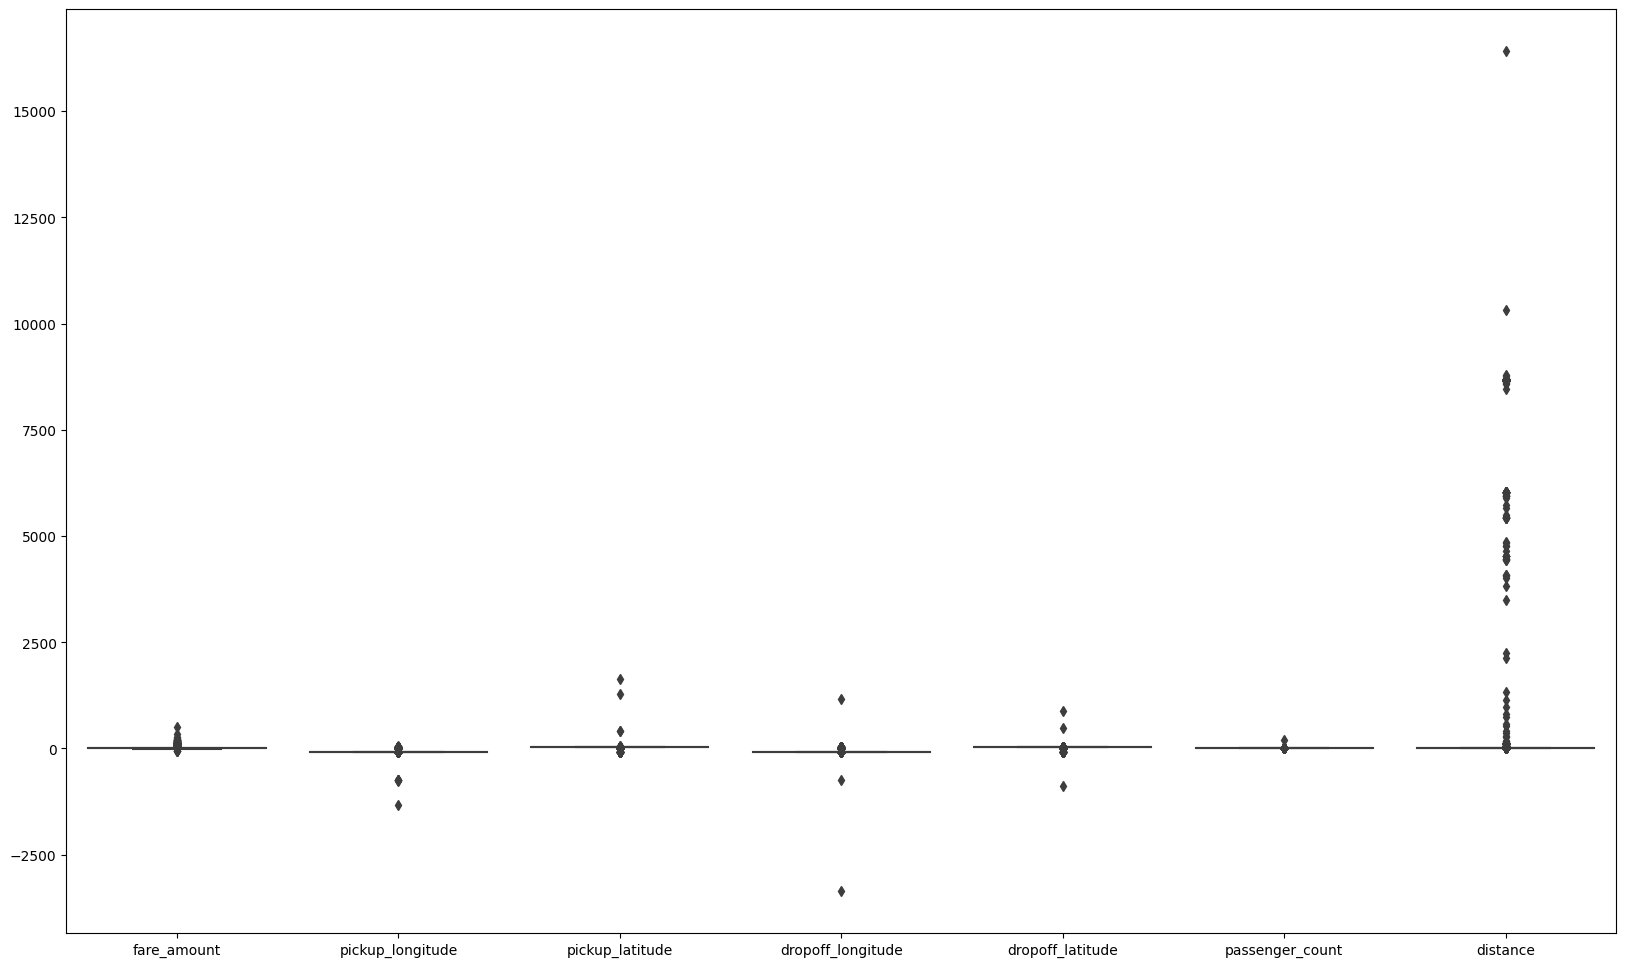

In [94]:
plt.figure(figsize=(20,12))
sns.boxplot(data = df)
plt.show()

Observation - distance column has very large number of outliers

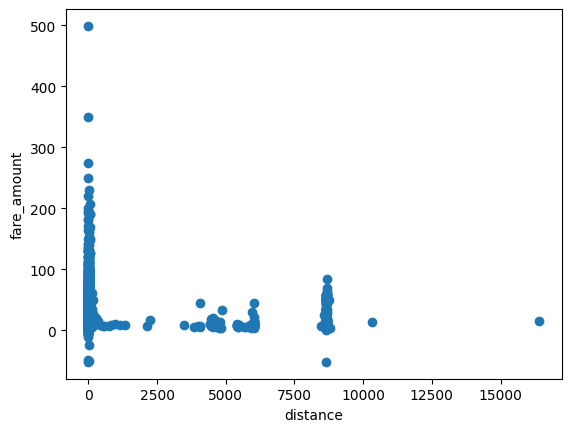

In [95]:
plt.scatter(df['distance'], df['fare_amount'])
plt.xlabel("distance")
plt.ylabel("fare_amount")
plt.show()

In [96]:
df.drop(df[df['distance'] >= 60].index, inplace = True)     # 1.
df.drop(df[df['fare_amount'] <= 0].index, inplace = True)   # 2.
df.drop(df[(df['fare_amount']>100) & (df['distance']<1)].index, inplace = True )    # 3.
df.drop(df[(df['fare_amount']<100) & (df['distance']>100)].index, inplace = True )  # 4.  

1. Removes rows from the DataFrame df where the 'distance' column is greater than or equal to 60.

2. Removes rows from the DataFrame df where the 'fare_amount' column is less than or equal to 0.

3. Removes rows from the DataFrame df where both conditions are met:
    'fare_amount' is greater than 100.
    'distance' is less than 1.

4. Removes rows from the DataFrame df where both conditions are met:
    'fare_amount' is less than 100.
    'distance' is greater than 100.

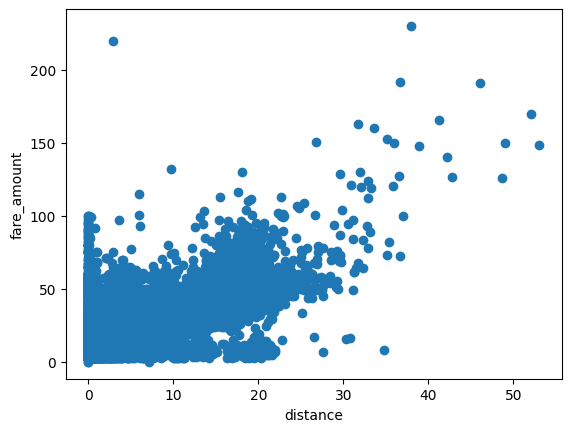

In [97]:
plt.scatter(df['distance'], df['fare_amount'])
plt.xlabel("distance")
plt.ylabel("fare_amount")
plt.show()

# Coorelation Matrix

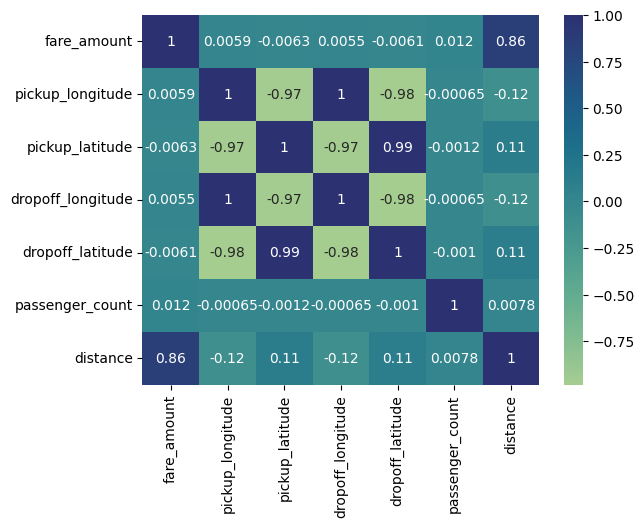

In [98]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='crest', annot=True)
plt.show()

# Dependent and Independent Variables

In [99]:
X = df['distance'].values.reshape(-1, 1)
y = df['fare_amount'].values.reshape(-1, 1)

In [100]:
std = StandardScaler()

x_std = std.fit_transform(X)
y_std = std.fit_transform(y)

StandardScaler is used for standardization or z-score normalization. It scales the data such that it has a mean of 0 and a standard deviation of 1. 

# Splitting the Dataset

In [101]:
X_train, X_test, y_train, y_test = train_test_split(x_std, y_std, test_size=0.2, random_state=0)

# Simple Linear Regression

In [102]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [103]:
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.7f}".format(lr.score(X_test, y_test)))

Training set score: 0.74
Test set score: 0.7340468


In [104]:
y_pred = lr.predict(X_test)
result = pd.DataFrame()
result[['Actual']] = y_test
result[['Predicted']] = y_pred
result.sample(10)

,Actual,Predicted
32551,-0.085865,0.069465
26261,-0.668906,-0.419871
23200,-0.668906,1.141156
18651,-0.606437,-0.503924
7182,-0.210803,-0.049691
27210,-0.137922,0.026657
17140,-0.543969,-0.579431
14405,-0.450266,-0.331154
31973,1.215564,0.560983
27066,-0.627260,-0.518363


Creating a DataFrame (result) to compare the actual and predicted values.

In [105]:
cols = ['Model', 'MSE', 'RMSE', 'R2']

lr_result = pd.DataFrame(columns = cols)

linreg_metrics = pd.DataFrame([[
    "Linear Regresion",
    metrics.mean_squared_error(y_test, y_pred),  # MSE
    np.sqrt(metrics.mean_squared_error(y_test, y_pred)),  # RMSE
    metrics.r2_score(y_test, y_pred)  # R2
    ]], columns = cols)

lr_result = pd.concat([lr_result, linreg_metrics], ignore_index=True)
lr_result

,Model,MSE,RMSE,R2
0,Linear Regresion,0.270524,0.52012,0.734047


# RandomForestRegressor

In [106]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=10)
rf_reg.fit(X_train, y_train)

n_estimators=100: This parameter specifies the number of decision trees (or estimators) that will be used in the random forest.
    
random_state=10: This parameter sets the random seed for reproducibility. 
By setting a random seed, you ensure that the randomness introduced in the algorithm is consistent across different runs

In [ ]:
print("Training set score: {:.2f}".format(rf_reg.score(X_train, y_train)))
print("Test set score: {:.7f}".format(rf_reg.score(X_test, y_test)))

Training set score: 0.92
Test set score: 0.6726491


In [ ]:
y_pred_RF = rf_reg.predict(X_test)
result = pd.DataFrame()
result[['Actual']] = y_test
result['Predicted'] = y_pred_RF
result.sample(10)

,Actual,Predicted
32084,-0.460677,-0.556358
37192,4.234881,6.600547
8563,-0.398208,-0.432879
22655,-0.450266,-0.431109
29665,-0.137922,0.403264
7062,-0.502323,-0.405705
34931,0.903221,0.085611
32890,-0.335740,-0.098359
17258,-0.543969,-0.420489
2794,-0.710552,-0.722212


Creating a DataFrame (result) to compare the actual and predicted values.

In [ ]:
cols = ['Model', 'MSE', 'RMSE', 'R2']

rf_reg_result = pd.DataFrame(columns = cols)

linreg_metrics = pd.DataFrame([[
    "Random Forest Regressor",
    metrics.mean_squared_error(y_test, y_pred_RF),  # MSE
    np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF)),  # RMSE
    metrics.r2_score(y_test, y_pred_RF)  # R2
    ]], columns = cols)

rf_reg_result = pd.concat([rf_reg_result, linreg_metrics], ignore_index=True)
rf_reg_result

,Model,MSE,RMSE,R2
0,Random Forest Regressor,0.332977,0.577042,0.672649


# Comparison

In [ ]:
result = pd.concat([lr_result, rf_reg_result])

In [ ]:
result

,Model,MSE,RMSE,R2
0,Linear Regresion,0.270524,0.520120,0.734047
0,Random Forest Regressor,0.332977,0.577042,0.672649
